### Imports

In [1]:
# ML imports
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, classification_report, roc_auc_score, RocCurveDisplay
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# Data analysis and stats imports
import numpy as np
import pandas as pd
from scipy.stats import expon, reciprocal
from scipy.spatial.distance import pdist, squareform

# Data visualization imports
import seaborn as sns
import matplotlib.pyplot as plt

from common_language import _LANGUAGES
import processing as prlib

c:\Users\Samir\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Get data

In [2]:
full_df, train_df, test_df, validation_df = prlib.get_preprocessed_data()
df_without_label = full_df.iloc[:, :-1]
df_without_label

,MFCC_mean_1,MFCC_mean_2,MFCC_mean_3,MFCC_mean_4,MFCC_mean_5,MFCC_mean_6,MFCC_mean_7,MFCC_mean_8,MFCC_mean_9,MFCC_mean_10,...,low_energy_frame_rate,mean_zcr,std_dev_zcr,median_zcr,min_zcr,max_zcr,q25_zcr,q75_zcr,iqr_zcr,hnr_mean
0,2.038479e-07,-8.821487e-08,4.470348e-09,8.344650e-09,1.376867e-07,1.192093e-09,4.291535e-08,-1.907349e-08,2.890825e-08,4.768372e-09,...,0.340000,0.185586,0.154883,0.145508,0.023438,0.673828,0.106934,0.204102,0.097168,8.933672
1,4.470348e-07,-5.960465e-08,0.000000e+00,9.934108e-09,2.483527e-08,5.960465e-08,-3.973643e-08,-1.986822e-08,-5.960465e-08,9.934108e-09,...,0.250000,0.099447,0.091187,0.071289,0.013672,0.312500,0.044434,0.083008,0.038574,14.682679
2,-5.765395e-07,1.219186e-07,1.408837e-08,7.369302e-08,4.118139e-08,5.526976e-08,-2.492558e-08,-8.669767e-08,1.950697e-08,-8.669766e-09,...,0.345455,0.180717,0.147784,0.125000,0.015625,0.710938,0.083008,0.232422,0.149414,8.667562
3,3.608497e-07,-1.610936e-08,-3.624607e-09,7.249214e-09,2.738592e-08,-2.738592e-08,1.288749e-08,4.832809e-09,4.832809e-09,-1.369296e-08,...,0.270270,0.183013,0.186445,0.107422,0.017578,0.771484,0.035156,0.257812,0.222656,9.699108
4,-1.655685e-07,-4.304780e-08,-1.986822e-08,1.655685e-09,3.311369e-08,1.324548e-08,2.980232e-08,-9.934108e-09,2.649095e-08,0.000000e+00,...,0.430556,0.150553,0.155056,0.081055,0.005859,0.630859,0.029297,0.260254,0.230957,6.527816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5873,-1.062718e-07,0.000000e+00,-7.392824e-09,-2.217847e-08,-7.392824e-09,-1.293744e-08,0.000000e+00,7.392824e-09,-2.310258e-08,7.392824e-09,...,0.534884,0.233164,0.252596,0.115234,0.000000,0.921875,0.048828,0.373047,0.324219,7.608964
5874,4.545711e-07,-6.285892e-08,7.707497e-09,-4.795776e-09,-1.460142e-08,-1.079050e-08,1.027666e-08,-1.126151e-08,6.165998e-09,2.569166e-08,...,0.482759,0.201419,0.204197,0.101562,0.003906,0.644531,0.062500,0.204102,0.141602,9.712304
5875,3.831727e-07,-2.554485e-08,-4.257475e-08,0.000000e+00,0.000000e+00,-4.257475e-08,-1.543335e-08,2.341611e-08,-1.277242e-08,0.000000e+00,...,0.660714,0.285854,0.285621,0.164062,0.000000,0.919922,0.060547,0.513184,0.452637,6.456141
5876,1.503041e-06,1.702990e-08,-4.409527e-09,3.649264e-09,2.250379e-08,2.311201e-08,-5.108970e-08,-2.493664e-08,-2.189558e-08,-1.338063e-08,...,0.469388,0.263732,0.225083,0.181641,0.005859,0.896484,0.086426,0.400391,0.313965,8.048931


Relabeling

In [3]:
# relabel by types of language, to group similar languages in one class
print(full_df['label'].unique())
group_labels = {
    'Arabic': 'Languages of the Caucasus and Middle East', 'Basque': 'Other European Languages',
    'Breton': 'Constructed and Isolate Languages', 'Catalan': 'Other European Languages',
    'Chinese_China': 'East Asian Languages', 'Chinese_Hongkong': 'East Asian Languages',
    'Chinese_Taiwan': 'East Asian Languages', 'Chuvash': 'Turkic Languages',
    'Czech': 'Slavic Languages', 'Dhivehi': 'Diverse Asian and Pacific Languages',
    'Dutch': 'Germanic Languages', 'English': 'Germanic Languages',
    'Esperanto': 'Constructed and Isolate Languages', 'Estonian': 'Other European Languages',
    'French': 'Romance European Languages', 'Frisian': 'African and Other Languages',
    'Georgian': 'Languages of the Caucasus and Middle East', 'German': 'Germanic Languages',
    'Greek': 'Romance European Languages', 'Hakha_Chin': 'Diverse Asian and Pacific Languages',
    'Indonesian': 'Diverse Asian and Pacific Languages', 'Interlingua': 'Constructed and Isolate Languages',
    'Italian': 'Romance European Languages', 'Japanese': 'East Asian Languages',
    'Kabyle': 'African and Other Languages', 'Kinyarwanda': 'African and Other Languages',
    'Kyrgyz': 'Turkic Languages', 'Latvian': 'Other European Languages',
    'Maltese': 'Languages of the Caucasus and Middle East', 'Mongolian': 'Diverse Asian and Pacific Languages',
    'Persian': 'Languages of the Caucasus and Middle East', 'Polish': 'Slavic Languages',
    'Portuguese': 'Romance European Languages', 'Romanian': 'Romance European Languages',
    'Romansh_Sursilvan': 'Constructed and Isolate Languages', 'Russian': 'Slavic Languages',
    'Sakha': 'Turkic Languages', 'Slovenian': 'Slavic Languages',
    'Spanish': 'Romance European Languages', 'Swedish': 'Germanic Languages',
    'Tamil': 'African and Other Languages', 'Tatar': 'Turkic Languages',
    'Turkish': 'Turkic Languages', 'Ukranian': 'Slavic Languages', 'Welsh': 'Other European Languages'
}

# Apply the mapping to the DataFrame
#full_df['label'] = full_df['label'].map(group_labels)
#print(full_df['label'].unique())
#full_df.groupby('label').count()

['Arabic' 'Basque' 'Breton' 'Catalan' 'Chinese_China' 'Chinese_Hongkong'
 'Chinese_Taiwan' 'Chuvash' 'Czech' 'Dhivehi' 'Dutch' 'English'
 'Esperanto' 'Estonian' 'French' 'Frisian' 'Georgian' 'German' 'Greek'
 'Hakha_Chin' 'Indonesian' 'Interlingua' 'Italian' 'Japanese' 'Kabyle'
 'Kinyarwanda' 'Kyrgyz' 'Latvian' 'Maltese' 'Mongolian' 'Persian' 'Polish'
 'Portuguese' 'Romanian' 'Romansh_Sursilvan' 'Russian' 'Sakha' 'Slovenian'
 'Spanish' 'Swedish' 'Tamil' 'Tatar' 'Turkish' 'Ukranian' 'Welsh']


Check multicolinearity

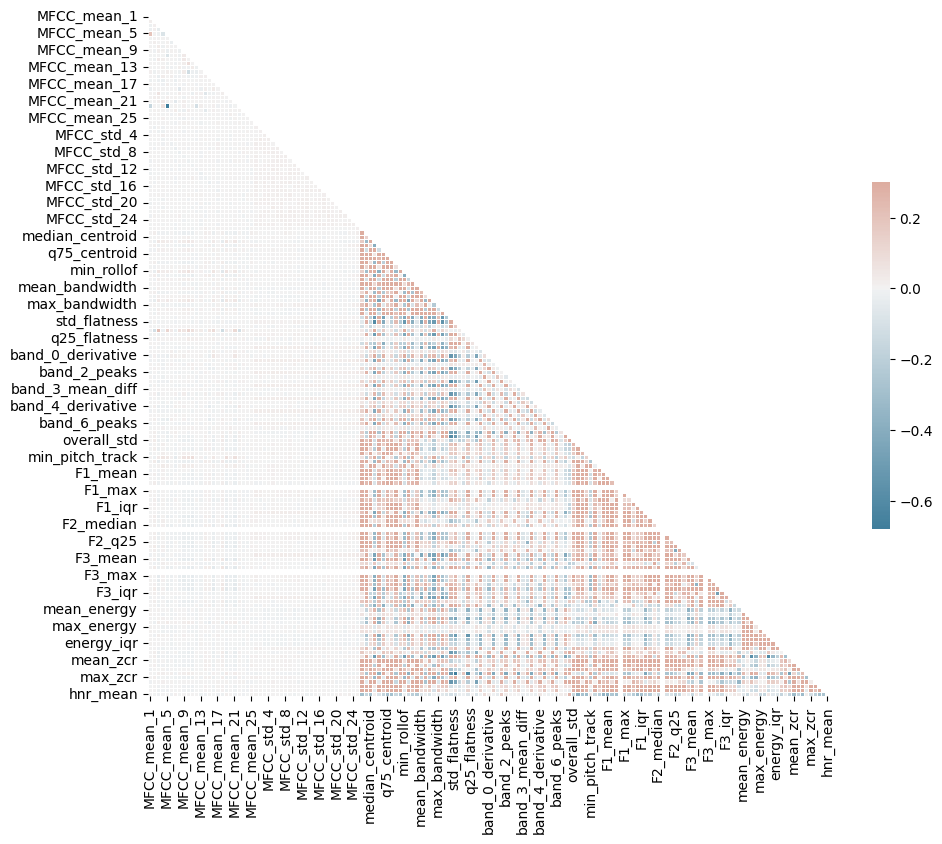

In [4]:
corr = df_without_label.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.savefig('C:/Users/Samir/Documents/GitHub/Projet-STT-3795/images/correlation_matrix.svg', format='svg')  # Save as SVG
plt.show()
plt.close() 

PCA or MDS

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(full_df.iloc[:, 0:-1], full_df['label'], stratify=full_df['label'], test_size=0.33, random_state=42)

#X_train, Y_train = df_without_label.iloc[:len(train_df), :], full_df['label'].iloc[:len(train_df)]
#X_test, Y_test = df_without_label.iloc[len(train_df):, :], full_df['label'].iloc[len(train_df):]

# PCA
X_train, embedding = prlib.get_PCs(X_train, 95)
X_test = embedding(X_test)

# MDS with mahalanobis
#df_mds = mds_mahalanobis(X_train, 70)
#df_mds['label'] = df['label']
X_train, X_test

## Models

### Training

In [ ]:
# Model initialization
svm = SVC(verbose=3, kernel='rbf', random_state=42, probability=True)
random_forest = RandomForestClassifier(verbose=3)

# Models fiting
print("Training SVM")
svm.fit(X_train, Y_train)
print("Training RFC")
random_forest.fit(X_train, Y_train)


### Predictions

In [ ]:
# Models prediction
mapper = {}
labels = full_df['label'].unique()
for i in range(len(labels)): 
    mapper[labels[i]] = i
svm_predictions = pd.Series(np.array(svm.predict(X_test))).replace(mapper)
p_svm = np.array(svm.predict_proba(X_test))
#prob_svm = np.exp(p_svm)/np.sum(np.exp(p_svm),axis=1, keepdims=True)
prob_svm = np.array(svm.predict_proba(X_test))
random_forest_predictions = pd.Series(random_forest.predict(X_test)).replace(mapper)
p_rfc = np.array(random_forest.predict_proba(X_test))
#prob_rfc = np.exp(p_rfc)/np.sum(np.exp(p_rfc),axis=1, keepdims=True)
#print(prob_rfc)

### Metrics

In [ ]:
Y_test = pd.Series(Y_test).replace(mapper)
#print(Y_test.shape, svm_predictions.shape)
svm_accuracy = accuracy_score(Y_test, svm_predictions)
#print(svm_predictions.to_list())
#print(prob_svm[0])
print("SVM AUC_ROC = ", roc_auc_score(svm_predictions.to_list(), prob_svm, multi_class="ovr"))
print("RFC ROC_AU = ", roc_auc_score(random_forest_predictions, p_rfc, multi_class="ovr",))
display = RocCurveDisplay.from_estimator(
    svm, 
    X_test, 
    Y_test, 
)
plt.show()

plt.show()
random_forest_accuracy = accuracy_score(Y_test, random_forest_predictions)
print("RFC ROC_AU = ", roc_auc_score(random_forest_predictions, prob_rfc, multi_class="ovr",))
display = RocCurveDisplay.from_predictions(
    svm_predictions, 
    Y_test,
    name="micro-average OvR",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Micro-averaged One-vs-Rest\nReceiver Operating Characteristic",
)
plt.show()
print(f'SVM accuracy: {svm_accuracy}')
print(f'RDF accuracy: {random_forest_accuracy}')

RandomizedSearch SVM

In [ ]:
param_grid_svm = {
    'C': reciprocal(0.001, 1000),
    'gamma': expon(scale=1.0),
    'kernel': ['linear', 'rbf', 'poly']
}

svm_clf = SVC(random_state=42)
random_search_svm = RandomizedSearchCV(svm_clf, param_distributions=param_grid_svm, n_iter=100, verbose=2, cv=5, random_state=42, n_jobs=-1, scoring = 'f1')
random_search_svm.fit(X_train, Y_train)
print("Best parameters for SVM:", random_search_svm.best_params_)
print("Best score:", random_search_svm.best_score_)

RandomizedSearch Random Forest Classifier

In [ ]:
param_grid_rf = {
    'n_estimators': [80, 100, 200],
    'max_depth': [3, 4, 5, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

rfc = RandomForestClassifier(random_state=42)

random_search_rf = RandomizedSearchCV(rfc, param_distributions=param_grid_rf, n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1, scoring = 'f1')
random_search_rf.fit(X_train, Y_train)
print("Best parameters:", random_search_rf.best_params_)
print("Best score:", random_search_rf.best_score_)